In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, PFNanoAODSchema
from coffea.nanoevents.methods import vector, candidate
import awkward as ak
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['blue', 'red', 'green', 'violet', 'darkorange', 'black', 'cyan', 'yellow'])
import mplhep as hep
plt.style.use(hep.style.CMS) # use CMS style for plotting

In [24]:
# fname = '/home/olympus/licq/data/calib/custom_nano/samples/20220506_fullAODGenPart/2017/mc/QCD_HT1000to1500_TuneCP5_PSWeights_13TeV-madgraph-pythia8/CustomNano_fullAODGenPart_PrivateMC/220508_021536/0000/nanov9_1.root'
# fname = '/home/olympus/licq/data/calib/custom_nano/samples/20221006_flvEnrichedQCD_fullAODGenPart/2017/mc/QCD_bbbEnriched_HT1000to1500/CustomNano_fullAODGenPart_PrivateMC/221006_211027/0000/nanov9_1.root'
# fname = '/home/pku/sdeng/sfbdt/20221109/full_tau21_10_10_fj1_sfBDT/mc/qcd-mg_tree.root'
fname = '/home/pku/sdeng/sfbdt/20221116/fullAOD_QCD_bbb.root'
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

mode = 'bb'

In [71]:
fname = '/home/olympus/licq/data/calib/custom_nano/samples/20221006_flvEnrichedQCD_fullAODGenPart/2017/mc/BulkGravitonToHHToBBorCC_MX-600to3000/CustomNano_fullAODGenPart_PrivateMC/221006_211321/0000/nanov9_6.root'
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

mode = 'sig'

## Quick ana

In [3]:
gpart = events.GenPart[0]

In [4]:
for i, gp in enumerate(gpart):
    if abs(gp.pdgId) > 100 and abs(gpart[gp.genPartIdxMother].pdgId) in [1,2,3,4,5,6]:
        print(i, '\t', gp.pdgId, '\t', gp.status, '\t', '%.2f'%gp.pt, '\t', gp.genPartIdxMotherG, '\t', gp.childrenIdxG, '\t', '\t', '\t')

727 	 -321 	 1 	 1.00 	 725 	 [] 	 	 	
728 	 213 	 2 	 0.36 	 725 	 [1022, 1023] 	 	 	
729 	 -211 	 1 	 0.87 	 725 	 [] 	 	 	
730 	 213 	 2 	 1.10 	 725 	 [1024, 1025] 	 	 	
735 	 423 	 2 	 2.96 	 731 	 [1148, 1149] 	 	 	
736 	 221 	 2 	 1.20 	 731 	 [1150, 1151] 	 	 	
737 	 111 	 2 	 2.89 	 731 	 [1152, 1153] 	 	 	
738 	 113 	 2 	 0.99 	 731 	 [1026, 1027] 	 	 	
739 	 221 	 2 	 3.30 	 731 	 [1154, 1155, 1156] 	 	 	
740 	 521 	 2 	 5.12 	 731 	 [1157, 1158, 1159] 	 	 	
747 	 1114 	 2 	 2.40 	 741 	 [1028, 1029] 	 	 	
748 	 -311 	 2 	 0.75 	 741 	 [1030] 	 	 	
749 	 -3114 	 2 	 2.41 	 741 	 [1031, 1032] 	 	 	
750 	 -211 	 1 	 0.13 	 741 	 [] 	 	 	
751 	 -421 	 2 	 1.09 	 741 	 [1160, 1161, 1162, 1163, 1164] 	 	 	
756 	 211 	 1 	 0.51 	 752 	 [] 	 	 	
757 	 313 	 2 	 0.08 	 752 	 [1033, 1034] 	 	 	
758 	 -313 	 2 	 0.14 	 752 	 [1035, 1036] 	 	 	
759 	 -213 	 2 	 0.59 	 752 	 [1037, 1038] 	 	 	
760 	 213 	 2 	 0.47 	 752 	 [1039, 1040] 	 	 	
761 	 -213 	 2 	 1.37 	 752 	 [1041, 1042] 	 	

## Visualize QCD with full GenPart

In [40]:
# fatjet match with two SV
fj_sv_comb = ak.cartesian([events.FatJet, events.SV], nested=True)
fj_sv_dr = fj_sv_comb['0'].delta_r(fj_sv_comb['1'])
fj_pass_nsv = ak.sum(fj_sv_dr < 0.8, axis=-1) >= 2

# each one of two subjets of a fatjet match with one SV
sj1 = events.SubJet[events.FatJet.subJetIdx1.mask[events.FatJet.subJetIdx1 >= 0]] # some fatjet has no subjet..
sj2 = events.SubJet[events.FatJet.subJetIdx2.mask[events.FatJet.subJetIdx2 >= 0]] # some fatjet has no subjet..
sj12_dr = sj1.delta_r(sj2)

sj1_sv_comb = ak.cartesian([sj1, events.SV], nested=True)
sj1_sv_dr = sj1_sv_comb['0'].delta_r(sj1_sv_comb['1'])
sj1_pass_nsv = ak.any(sj1_sv_dr < np.minimum(0.4, sj12_dr), axis=-1)
sj2_sv_comb = ak.cartesian([sj2, events.SV], nested=True)
sj2_sv_dr = sj2_sv_comb['0'].delta_r(sj2_sv_comb['1'])
sj2_pass_nsv = ak.any(sj2_sv_dr < np.minimum(0.4, sj12_dr), axis=-1)
# recover None entries (with no subjet)
sj1_pass_nsv = ak.fill_none(sj1_pass_nsv, False)
sj2_pass_nsv = ak.fill_none(sj2_pass_nsv, False)

if mode == 'bb':
    fj_pass_nhad = events.FatJet.nBHadrons >= 2
elif mode == 'cc':
    fj_pass_nhad = (events.FatJet.nBHadrons == 0) & (events.FatJet.nCHadrons >= 2)

fj_pass = fj_pass_nsv & fj_pass_nhad & sj1_pass_nsv & sj2_pass_nsv

# selection
evt = events[ak.sum(fj_pass, axis=-1) >= 1]
evt_fj_pass = fj_pass[ak.sum(fj_pass, axis=-1) >= 1]

In [43]:
evt = events

In [7]:
# then pass scores
fjs = evt.FatJet[evt_fj_pass]
if mode == 'bb':
    fj_dist = fjs.particleNetMD_Xbb / (fjs.particleNetMD_Xbb + fjs.particleNetMD_QCD)
elif mode == 'cc':
    fj_dist = fjs.particleNetMD_Xcc / (fjs.particleNetMD_Xcc + fjs.particleNetMD_QCD)
evt_pass_tp = ak.fill_none(ak.max(fj_dist, axis=-1) > 0.9, False)
evt_pass_mp = ak.fill_none((ak.max(fj_dist, axis=-1) > 0.8) & (ak.max(fj_dist, axis=-1) < 0.9), False)


In [44]:
def make_subplot(ax, tree, tree_fj_pass):
    # default plotting configuration
    f = lambda x: np.sqrt(x)/100
    alpha = 0.2

    def color_opt(color, fill=True):
        if fill:
            return {'facecolor': color}
        else:
            return {'edgecolor': color, 'linewidth': 2, 'fill': False, 'hatch': '///'}
    # jet
    fj = tree.FatJet
    for pt, eta, phi, ispass, t_bb, t_cc, t_qcd in zip(fj.pt, fj.eta, fj.phi, tree_fj_pass, fj.particleNetMD_Xbb, fj.particleNetMD_Xcc, fj.particleNetMD_QCD):
        edgecolor = 'red' if ispass else 'grey'
        # ax.add_patch(plt.Circle((eta, phi), radius=f(pt), clip_on=True, alpha=alpha, **color_opt('grey', fill=True)))
        ax.add_patch(plt.Circle((eta, phi), radius=0.8, clip_on=True, fill=False, edgecolor=edgecolor, linestyle=':'))
#         ax.text(eta-0.6, phi+0.9, f'{t_bb:.3f}', fontsize=20, ha='center', va='center', color='purple')
#         ax.text(eta, phi+0.9, f'{t_cc:.3f}', fontsize=20, ha='center', va='center', color='deepskyblue')
#         ax.text(eta+0.6, phi+0.9, f'{t_qcd:.3f}', fontsize=20, ha='center', va='center', color='grey')
#         ax.text(eta-0.3, phi+0.75, f'{(t_bb/(t_bb + t_qcd)):.3f}', fontsize=20, ha='center', va='center', color='purple')
#         ax.text(eta+0.3, phi+0.75, f'{(t_cc/(t_cc + t_qcd)):.3f}', fontsize=20, ha='center', va='center', color='deepskyblue')
        ax.text(eta-0.3, phi+1.10, f'ParticleNetMD_XbbVsQCD: {(t_bb/(t_bb + t_qcd)):.3f}', fontsize=20, ha='center', va='center', color='purple')
        ax.text(eta-0.3, phi+1.50, f'ParticleNetMD_XccVsQCD: {(t_cc/(t_cc + t_qcd)):.3f}', fontsize=20, ha='center', va='center', color='deepskyblue')
    # subjets
    sj = tree.SubJet
    for pt, eta, phi in zip(sj.pt, sj.eta, sj.phi):
        ax.add_patch(plt.Circle((eta, phi), radius=f(pt), clip_on=True, alpha=alpha, **color_opt('grey', fill=False)))
     # SV
    sv = tree.SV
    for pt, eta, phi in zip(sv.pt, sv.eta, sv.phi):
        ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 4, radius=f(pt)*5, clip_on=True, alpha=alpha, **color_opt('orange', fill=True)))
    # partons/hadrons
    for gp in tree.GenPart:
        if abs(gp.pdgId) > 100 and abs(tree.GenPart[gp.genPartIdxMother].pdgId) in [1,2,3,4,5,6]:
            pt, eta, phi, pid = gp.pt, gp.eta, gp.phi, gp.pdgId
            pid = abs(gp.pdgId)
            if (pid >= 400 and pid < 500) or (pid >= 4000 and pid < 5000):
                color = 'deepskyblue'
            elif (pid >= 500 and pid < 600) or (pid >= 5000 and pid < 6000):
                color = 'purple'
            else:
                color = 'grey'
            ax.add_patch(plt.Circle((eta, phi), radius=f(pt), clip_on=True, alpha=alpha, **color_opt(color, fill=True)))

    ax.set_xlim(-4, 4); ax.set_ylim(-4, 4)
    ax.set_xlabel(r'$\eta$'); ax.set_ylabel(r'$\phi$')
    ax.set_aspect('equal')


In [22]:
evt[evt_pass_tp]

<NanoEventsArray [<event 1:1:11>, ... <event 1:10:993>] type='9541 * event'>

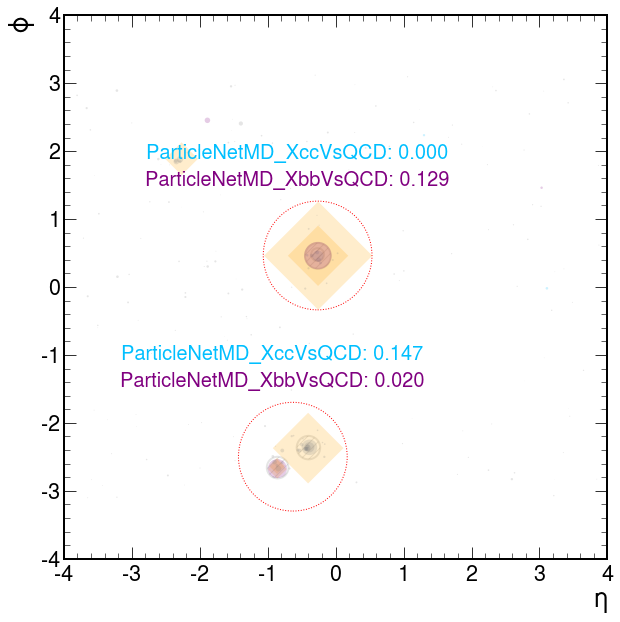

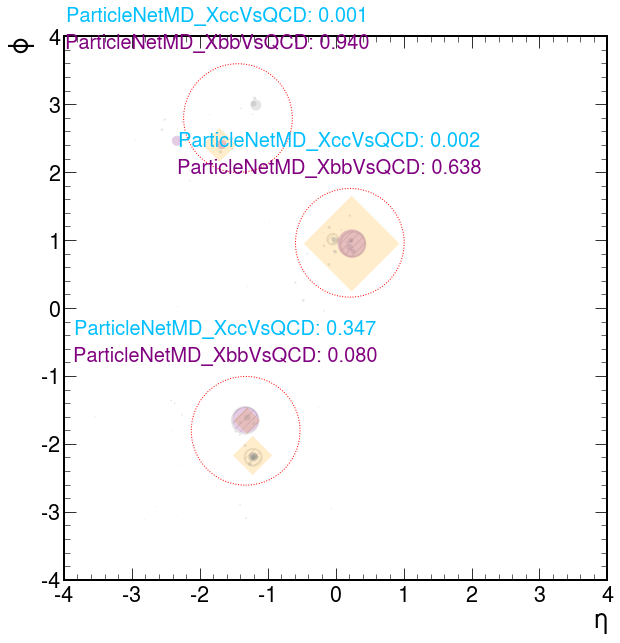

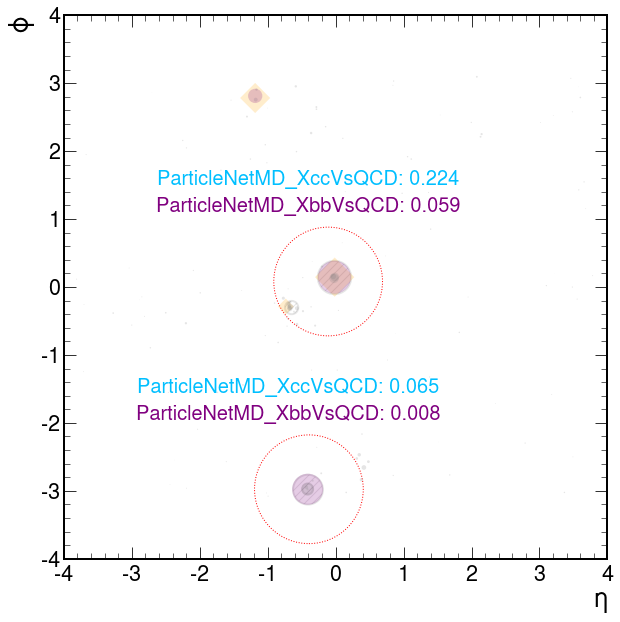

In [46]:
assert mode in ['bb', 'cc']
from tqdm import trange
# for i in trange(30):
for i in [9115, 13468, 16545]:
    # fig, ax = plt.subplots(figsize=(30, 30))
    # make_subplot(ax, evt[i], evt_fj_pass[i])
    # plt.savefig(f"../plots/event_vis/qcd_bbb_fullgenp/{i:03d}.png")
    # plt.close()

    fig, ax = plt.subplots(figsize=(10, 10))
#     make_subplot(ax, evt[evt_pass_tp][i], evt_fj_pass[evt_pass_tp][i])
    make_subplot(ax, evt[i], evt[i].FatJet.pt>-1)
    plt.savefig(f"./plots/20221116/tp_{i:03d}.png")
#     plt.close()

#     fig, ax = plt.subplots(figsize=(10, 10))
#     make_subplot(ax, evt[evt_pass_mp][i], evt_fj_pass[evt_pass_mp][i])
#     plt.savefig(f"./plots/20221116/mp_{i:03d}.png")
#     plt.close()

In [ ]:
assert mode == 'sig'
from tqdm import trange
for i in trange(30):
    fig, ax = plt.subplots(figsize=(30, 30))
    make_subplot(ax, events[i], events.FatJet.pt[i]>0)
    # plt.savefig(f"test.png")
    plt.savefig(f"../plots/20221116/event_vis/sig_fullgenp/{i:03d}.png")
    plt.close()

# Testing fastjet

In [15]:
import fastjet
from coffea.nanoevents.methods import vector

In [21]:
parts = ak.zip({
    'x': [[1.1, 2.1, 3.1, 4.1, 5.1]],
    'y': [[1.2, 2.2, 3.2, 4.2, 5.2]],
    'z': [[1.3, 2.3, 3.3, 4.3, 5.3]],
    't': [[1.4, 2.4, 3.4, 4.4, 5.4]]},
    behavior=vector.behavior,
    with_name='LorentzVector',
)
parts['E'] = parts.t

In [40]:
parts = ak.zip({
    'pt': [[1.1, 2.1, 3.1, 4.1, 5.1]],
    'eta': [[1.2, 2.2, 3.2, 4.2, 5.2]],
    'phi': [[1.3, 2.3, 3.3, 4.3, 5.3]],
    'mass': [[1.4, 2.4, 3.4, 4.4, 5.4]]},
    behavior=vector.behavior,
    with_name='PtEtaPhiMLorentzVector',
)
parts['E'] = parts.t

In [41]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm, 1.5)
cluster = fastjet.ClusterSequence(parts, jetdef)

# # extract jet clustering history
# order_array = cluster.unique_history_order()

In [43]:
jets = cluster.inclusive_jets()
subjets = cluster.exclusive_subjets_up_to(jets, nsub=6)
subjets = ak.zip(
    {'x': subjets.px, 'y': subjets.py, 'z': subjets.pz, 't': subjets.E},
    behavior=vector.behavior,
    with_name='LorentzVector',
)
for j in subjets[0]:
    print(j.pt, j.eta, j.phi, j.mass)

3.1 3.2 -2.983185307179587 3.400000000000059
4.1 4.2 -1.9831853071795866 4.400000000000066


In [72]:
subjets = cluster.exclusive_subjets_up_to(jets, nsub=3)
subjets = ak.zip(
    {'x': subjets.px, 'y': subjets.py, 'z': subjets.pz, 't': subjets.E},
    behavior=vector.behavior,
    with_name='LorentzVector',
)


In [75]:
comb = ak.cartesian([parts, subjets], nested=True)
ak.sum(parts.pt * ak.min(comb['0'].delta_r(comb['1']), axis=2), axis=1) / (ak.sum(parts.pt, axis=1) * 0.8)

<Array [0.00319] type='1 * float64'>

In [69]:
print(comb['0'].delta_r(comb['1'])[0])

[[0, 0.0391, 0.0578], [0.0391, 0, ... 0.0145, 0.00428], [0.0611, 0.022, 0.00326]]


# Test pyjet

In [1]:
from pyjet import cluster
from pyjet.testdata import get_event

vectors = get_event()
sequence = cluster(vectors, R=1.0, p=-1)
jets = sequence.inclusive_jets()  # list of PseudoJets
exclusivejets = sequence.exclusive_jets(3)  # Find the cluster history when there are 3 jets

WARNING from FastJet: dcut and exclusive jets for jet-finders other than kt, C/A or genkt with p>=0 should be interpreted with care.


In [57]:
parts = np.array([
    (1.1, 1.2, 1.3, 1.4),
    (2.1, 2.2, 2.3, 2.4),
    (3.1, 3.2, 3.3, 3.4),
    (4.1, 4.2, 4.3, 4.4),
    (5.1, 5.2, 5.3, 5.4)],
    dtype=[('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]
)

In [58]:
len(parts)

5

In [46]:
# jetdef = pyjet.JetDefinition(pyjet.kt_algorithm, 1.5)
# cluster = pyjet.ClusterSequence(parts, jetdef)
from pyjet import cluster
sequence = cluster(parts, algo='kt', R=1.5)
subjets = sequence.exclusive_jets(2)

In [47]:
for j in subjets:
    print(j.pt, j.eta, j.phi, j.mass)

6.336756632155611 4.009827100734706 -2.4074550669780734 10.160776745632898
5.1 5.2 -0.9831853071795864 5.400000000001391


In [48]:
subjets.pt

AttributeError: 'list' object has no attribute 'pt'

In [51]:
import awkward as ak
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['blue', 'red', 'green', 'violet', 'darkorange', 'black', 'cyan', 'yellow'])
import mplhep as hep
plt.style.use(hep.style.CMS) # use CMS style for plotting

In [53]:
df = uproot.lazy("~/QCD_bbbEnriched_HT300to500_0_tree.root:Events")

/home/olympus/licq/utils/miniconda3/envs/weaver/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


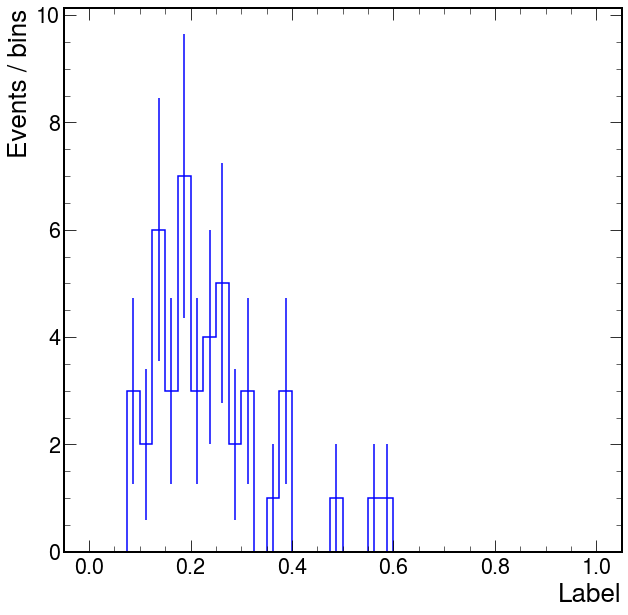

In [55]:
import boost_histogram as bh
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.ROOT)

f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 1
hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

hist.fill(df.fj_1_matchedInitHadsTau2 / df.fj_1_matchedInitHadsTau1)

content, yerr = hist.view().value, np.sqrt(hist.view().variance)
hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr)
ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);

In [56]:
df.fj_1_matchedInitHadsTau2

<Array [0.0444, 0, 0.0993, ... 0, 0.0767, 0] type='73 * float32'>